In [28]:
#%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import *
import numpy as np
provider = IBMQ.load_account()

    
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

#contants
n = 4
lambd = 1.0

def thetak(k):
    num = lambd - np.cos(2*np.pi*k/n)
    denom = np.sqrt( (lambd-np.cos(2*np.pi*k/n))**2 + np.sin(2*np.pi*k/n)**2)
    theta = np.arccos(num/denom)
    return theta

#Create functions based on the decomposition included in appendix of Ising paper
def bog(qcirc, q1, q2, theta):
    qcirc.x(q2)
    qcirc.cnot(q2, q1)
    #Controlled RX gate
    qcirc.rz(np.pi/2, q2)
    qcirc.ry(theta/2, q2)
    qcirc.cnot(q1, q2)
    qcirc.ry(-theta/2, q2)
    ######################
    qcirc.cnot(q2, q1)
    qc.rz(-np.pi/2, q2)
    qcirc.barrier()
    return qcirc
    
def fourier(qcirc, q1, q2, phase):
    qcirc.rz(phase, q1)
    qcirc.cnot(q1, q2)
    #Controlled Hadamard
    qcirc.sdg(q2)
    qcirc.h(q2)
    qcirc.tdg(q2)
    qcirc.cnot(q1, q2)
    qcirc.t(q2)
    qcirc.h(q2)
    qcirc.s(q2)
    ####################
    qcirc.cnot(q1, q2)
    qcirc.cz(q1, q2)
    qcirc.barrier()
    return qcirc

#create quantum circuit
qc = QuantumCircuit(4, 4)
#Set correct ground state if lambda < 1
if lambd < 1:
    qc.x(3)
    qc.barrier()

#Apply disentangling gates
qc = bog(qc, 0, 1, thetak(1.))
qc = fourier(qc, 0, 1, 2*np.pi/n)
qc = fourier(qc, 2, 3, 0.)
qc = fourier(qc, 0, 1, 0.)
qc = fourier(qc, 2, 3, 0.)

'''
#create Quantum operators

F1_dag = Operator([
    [1, 0, 0, 0],
    [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
    [0, 1/np.sqrt(2)*np.exp(-2*np.pi*1j/n), -1/np.sqrt(2)*np.exp(-2*np.pi*1j/n), 0],
    [0, 0, 0, -np.exp(-2*np.pi*1j/n)]])

F0_dag = Operator([
    [1, 0, 0, 0],
    [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
    [0, 1/np.sqrt(2), -1/np.sqrt(2), 0],
    [0, 0, 0, -1]])
B1_dag = Operator([
    [np.cos(thetak(1.)/2), 0, 0, -1j*np.sin(thetak(1.)/2)],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [ -1j*np.sin(thetak(1.)/2),0,0,np.cos(thetak(1.)/2)]])

fswap = Operator([
        [1,0,0,0],
        [0,0,1,0],
        [0,1,0,0],
        [0,0,0,-1]
])

#Create quantum Gates
qc.unitary(B1_dag, [0, 1], label='B1_dag')
qc.unitary(F1_dag, [0, 1], label='F1_dag')
qc.unitary(F0_dag, [2, 3], label='F0_dag')
qc.unitary(fswap,[1,2],label ='fSWAP')
qc.unitary(F0_dag, [0, 1], label='F0_dag')
qc.unitary(F0_dag, [2, 3], label='F0_dag')
qc.unitary(fswap,[1,2],label ='fSWAP')
'''    

#Set measurement step
for i in range(0,4):
    qc.measure(i,i)

#display circuit
qc.draw()


ibmqfactory.load_account:WARNING:2021-02-12 10:53:27,712: Credentials are already in use. The existing account in the session will be replaced.


┌───┐                                       ┌───┐             ░ »
q_0: ─────┤ X ├────────────────────────■──────────────┤ X ├─────────────░─»
     ┌───┐└─┬─┘┌─────────┐┌─────────┐┌─┴─┐┌──────────┐└─┬─┘┌──────────┐ ░ »
q_1: ┤ X ├──■──┤ RZ(π/2) ├┤ RY(π/8) ├┤ X ├┤ RY(-π/8) ├──■──┤ RZ(-π/2) ├─░─»
     └───┘     └─────────┘└─────────┘└───┘└──────────┘     └──────────┘ ░ »
q_2: ───────────────────────────────────────────────────────────────────░─»
                                                                        ░ »
q_3: ───────────────────────────────────────────────────────────────────░─»
                                                                        ░ »
c: 4/═════════════════════════════════════════════════════════════════════»
                                                                          »
«     ┌─────────┐                                                     ░ »
«q_0: ┤ RZ(π/2) ├──■───────────────────────■───────────────────■───■──░─»
«     └─────────┘┌─┴─┐┌─────┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐ │  ░ »
«q_1: ───────────┤ X ├┤ SDG ├┤ H ├┤ TDG ├┤ X ├┤ T ├┤ H ├┤ S ├┤ X ├─■──░─»
«                └───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘    ░ »
«q_2: ────────────────────────────────────────────────────────────────░─»
«                                                                     ░ »
«q_3: ────────────────────────────────────────────────────────────────░─»
«                                                                     ░ »
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                   ░ ┌───────┐»
«q_0: ──────────────────────────────────────────────────────────────░─┤ RZ(0) ├»
«                                                                   ░ └───────┘»
«q_1: ──────────────────────────────────────────────────────────────░──────────»
«     ┌───────┐                                                     ░          »
«q_2: ┤ RZ(0) ├──■───────────────────────■───────────────────■───■──░──────────»
«     └───────┘┌─┴─┐┌─────┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐ │  ░          »
«q_3: ─────────┤ X ├┤ SDG ├┤ H ├┤ TDG ├┤ X ├┤ T ├┤ H ├┤ S ├┤ X ├─■──░──────────»
«              └───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘    ░          »
«c: 4/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                          ░               »
«q_0: ──■───────────────────────■───────────────────■───■──░───────────────»
«     ┌─┴─┐┌─────┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐ │  ░               »
«q_1: ┤ X ├┤ SDG ├┤ H ├┤ TDG ├┤ X ├┤ T ├┤ H ├┤ S ├┤ X ├─■──░───────────────»
«     └───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘    ░ ┌───────┐     »
«q_2: ─────────────────────────────────────────────────────░─┤ RZ(0) ├──■──»
«                                                          ░ └───────┘┌─┴─┐»
«q_3: ─────────────────────────────────────────────────────░──────────┤ X ├»
«                                                          ░          └───┘»
«c: 4/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                     ░ ┌─┐         
«q_0: ────────────────────────────────────────────────░─┤M├─────────
«                                                     ░ └╥┘┌─┐      
«q_1: ────────────────────────────────────────────────░──╫─┤M├──────
«                                                     ░  ║ └╥┘┌─┐   
«q_2: ─────────────────────■───────────────────■───■──░──╫──╫─┤M├───
«     ┌─────┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐ │  ░  ║  ║ └╥┘┌─┐
«q_3: ┤ SDG ├┤ H ├┤ TDG ├┤ X ├┤ T ├┤ H ├┤ S ├┤ X ├─■──░──╫──╫──╫─┤M├
«     └─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘    ░  ║  ║  ║ └╥┘
«

$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$ \newcommand{\bra}[1]{\left\langle{#1}\right|}$
$$ \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

when it comes to implementation:  
first try to run circuit on simulator 
second try to run on real hardware

long term goal is reproduce figures 5 (Ground state of a spin chain)and 6 (time evolution of operator $\sigma_z$) 

short term goal is initialize the state to  $ \ket{0000}  $ and $\ket{ 1100} $

Job Status: job has successfully run


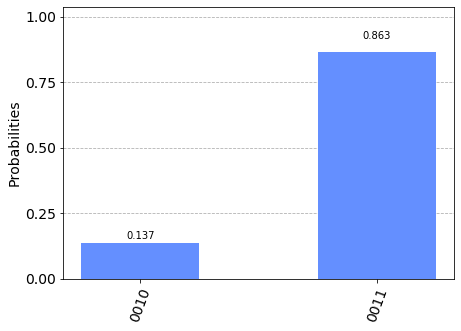

In [29]:
#Start up and initialize circuit
#Measurement

    
    #Choose provider and backend
#provider = IBMQ.get_provider()
#provider = AerProvider()
#backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = provider.get_backend('ibmqx4')
#backend = provider.get_backend('ibmqx2')
#backend = provider.get_backend('ibmq_16_melbourne')

shots = 1024
max_credits = 10 #Max number of credits to spend on execution
job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)



In [31]:
phi = np.arccos(lambd/np.sqrt(1+lambd**2))/2
#print(result.get_statevector(qc))
print("|0000> probability should be: ",np.cos(phi)**2)
print("|0011> probability should be: ",np.sin(phi)**2 )

|0000> probability should be:  0.8535533905932737
|0011> probability should be:  0.14644660940672624
